## Transfer learning for VGG16 (based on https://www.tensorflow.org/tutorials/images/transfer_learning)

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, LeakyReLU, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Unzip the dataset from the Google Drive folder. The extracted images will go into the
# "/content/Facial_emotion_images" folder.
from zipfile import ZipFile
file_name = "/content/drive/My Drive/annam/adsp/facial-emotion/Facial_emotion_images.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Zip extraction done!')

# Define the paths to the training and validation directories.
DATA_PATH = '/content/Facial_emotion_images/'
train_path = DATA_PATH + 'train/'
validation_path = DATA_PATH + 'validation/'
test_path = DATA_PATH + 'test/'

BATCH_SIZE = 32
IMG_SIZE = (48, 48)

# Create a data load function for data
def load_data(full_data_path, color_mode='rgb', target_size=(48, 48), batch_size=BATCH_SIZE):
  datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
                               zoom_range=0.2, horizontal_flip=True, brightness_range=[0.2, 1.2])
  return datagen.flow_from_directory(full_data_path, target_size=target_size, color_mode=color_mode,
                                     batch_size=batch_size, class_mode='categorical', shuffle=True)

# Create a data load function for training data
def load_train_data(color_mode='rgb', target_size=(48, 48), batch_size=BATCH_SIZE):
  return load_data(train_path, color_mode, target_size, batch_size=batch_size)

# Create a data load function for validation data
def load_val_data(color_mode='rgb', target_size=(48, 48), batch_size=BATCH_SIZE):
  return load_data(validation_path, color_mode, batch_size=batch_size)

# Create a data load function for test data
def load_test_data(color_mode='rgb', target_size=(48, 48), batch_size=BATCH_SIZE):
  # Do not shuffle or otherwise modify the data set. To be used with test data.
  datagen = ImageDataGenerator()
  return datagen.flow_from_directory(test_path, target_size=target_size, color_mode=color_mode, batch_size=batch_size,
                                     class_mode='categorical', shuffle=False)

Zip extraction done!


In [4]:
data_augmentation = tf.keras.Sequential()

In [5]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [6]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 2s 0us/step


In [7]:
image_batch, label_batch = next(iter(load_train_data()))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

Found 15109 images belonging to 4 classes.
(32, 1, 1, 512)


In [8]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [9]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [10]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [11]:
inputs = tf.keras.Input(shape=(48, 48, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 tf.__operators__.getitem (  (None, 48, 48, 3)         0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 48, 48, 3)         0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0     

In [13]:
len(model.trainable_variables)

2

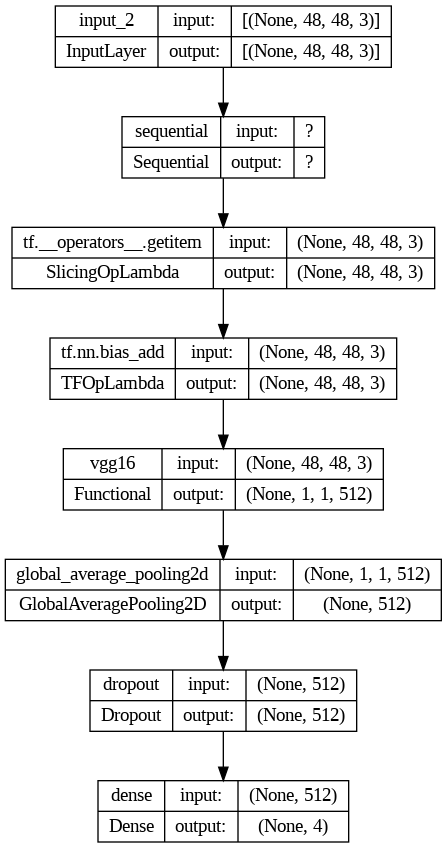

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

base_learning_rate = 0.0001
model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer=Adam(learning_rate=base_learning_rate),
              metrics=CategoricalAccuracy(name='accuracy'))


In [16]:
initial_epochs = 10

validation_data = load_val_data()
loss0, accuracy0 = model.evaluate(validation_data)

Found 4977 images belonging to 4 classes.
156/156 [==============================] - 10s 61ms/step - loss: 10.3254 - accuracy: 0.2795


In [17]:
train_data = load_train_data()
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=validation_data)

Found 15109 images belonging to 4 classes.
Epoch 1/10
473/473 [==============================] - 53s 105ms/step - loss: 10.6532 - accuracy: 0.2837 - val_loss: 7.1483 - val_accuracy: 0.3108
Epoch 2/10
473/473 [==============================] - 46s 97ms/step - loss: 7.9011 - accuracy: 0.3198 - val_loss: 5.4117 - val_accuracy: 0.3408
Epoch 3/10
473/473 [==============================] - 37s 78ms/step - loss: 6.3092 - accuracy: 0.3446 - val_loss: 4.4855 - val_accuracy: 0.3637
Epoch 4/10
473/473 [==============================] - 39s 82ms/step - loss: 5.2514 - accuracy: 0.3585 - val_loss: 3.7977 - val_accuracy: 0.3763
Epoch 5/10
473/473 [==============================] - 40s 85ms/step - loss: 4.3715 - accuracy: 0.3680 - val_loss: 3.2372 - val_accuracy: 0.3924
Epoch 6/10
473/473 [==============================] - 37s 79ms/step - loss: 3.6849 - accuracy: 0.3775 - val_loss: 2.8618 - val_accuracy: 0.3928
Epoch 7/10
473/473 [==============================] - 37s 78ms/step - loss: 3.1873 - accura

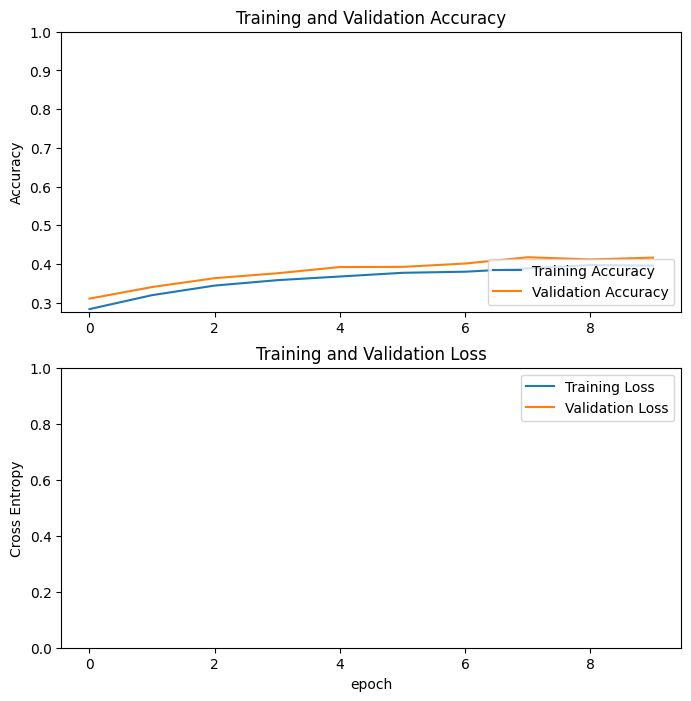

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
base_model.trainable = True

In [20]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 4

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  19


In [21]:
model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer=RMSprop(learning_rate=base_learning_rate/10),
              metrics=CategoricalAccuracy(name='accuracy'))

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 tf.__operators__.getitem (  (None, 48, 48, 3)         0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 48, 48, 3)         0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0     

In [23]:
len(model.trainable_variables)

24

In [24]:
fine_tune_epochs = 40
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_data)

Epoch 10/50
473/473 [==============================] - 44s 86ms/step - loss: 1.1732 - accuracy: 0.4868 - val_loss: 0.9975 - val_accuracy: 0.5883
Epoch 11/50
473/473 [==============================] - 40s 85ms/step - loss: 0.9865 - accuracy: 0.5932 - val_loss: 0.8815 - val_accuracy: 0.6409
Epoch 12/50
473/473 [==============================] - 42s 88ms/step - loss: 0.9051 - accuracy: 0.6243 - val_loss: 0.8601 - val_accuracy: 0.6498
Epoch 13/50
473/473 [==============================] - 38s 81ms/step - loss: 0.8620 - accuracy: 0.6446 - val_loss: 0.8444 - val_accuracy: 0.6598
Epoch 14/50
473/473 [==============================] - 41s 87ms/step - loss: 0.8267 - accuracy: 0.6637 - val_loss: 0.7854 - val_accuracy: 0.6735
Epoch 15/50
473/473 [==============================] - 39s 83ms/step - loss: 0.7997 - accuracy: 0.6747 - val_loss: 0.7915 - val_accuracy: 0.6821
Epoch 16/50
473/473 [==============================] - 41s 87ms/step - loss: 0.7804 - accuracy: 0.6804 - val_loss: 0.7416 - val_ac

In [25]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

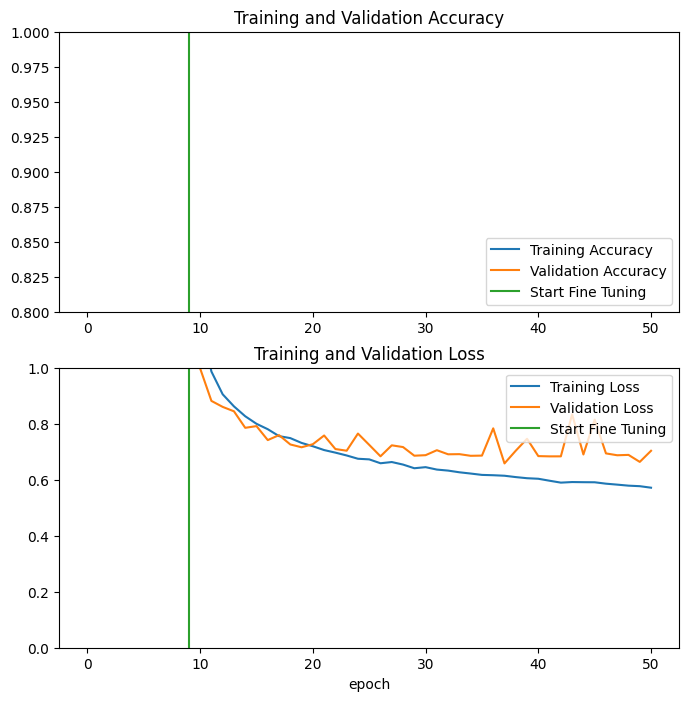

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
test_data = load_test_data()
loss, accuracy = model.evaluate(test_data)
print('Test accuracy :', accuracy)

Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 15ms/step - loss: 0.5171 - accuracy: 0.8125
Test accuracy : 0.8125


In [28]:
# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [29]:
# Given a model, plot the confusion matrix, calculate the precision, recall and F1 Score
def plot_model_performance(model, color_mode='rgb'):
  # Load the test data
  test_data = load_test_data(color_mode)
  y_true = test_data.classes
  y_pred = np.argmax(model.predict(test_data), axis=-1)
  cm = confusion_matrix(y_true, y_pred)

  # Plot the confusion matrix
  plot_confusion_matrix(cm, classes=['Happy', 'Neutral', 'Sad', 'Surprise'], normalize=True, title='Normalized Confusion Matrix')

  # Calculate Precision, Recall and F1 Score
  precision, recall, f1score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
  print('Precision: ', precision)
  print('Recall: ', recall)
  print('F1 Score: ', f1score)

Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 14ms/step


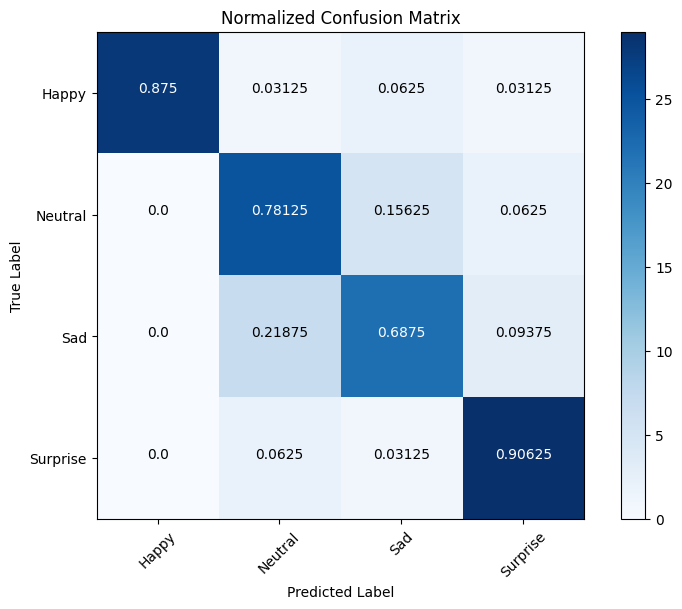

Precision:  0.8190476190476191
Recall:  0.8125
F1 Score:  0.8137377627989086


In [30]:
plot_model_performance(model)

In [32]:
!pip install tensorflowjs
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, '/content/drive/My Drive/annam/adsp/facial-emotion/tfjs')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 17.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
